<a href="https://colab.research.google.com/github/YinGuoX/Deep_Learning_Keras_WithDeeplizard/blob/master/21_Mapping_Keras_Labels_To_Image_Classes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Mapping Keras Labels To Image Classes
在Stackoverflow、Reddit等网站上有很多问题，都是关于Keras中的图像标签的特定问题。之前没有讲过这个问题，因此将在这节课里快速地讲一下。

这个挥之不去的神秘问题是……

* 当使用Keras ImageDataGenerator时，我们如何查看Keras分配给相应图像的类的id或标签

不可否认，这是一个有点复杂的问题，特别是没有任何上下文，但幸运的是，我们将看到答案是相当直接的。

不过，在我们得到答案之前，让我们先回忆一下之前讨论过的一些话题，这样我们就可以了解一些背景，看看这个问题会在哪里发挥作用。

## 1.理解Keras如何标记数据
在前几集中，我们通过设置准备一组猫和狗的图像数据来训练一个CNN。


In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense, Flatten, BatchNormalization, Conv2D, MaxPool2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix
import itertools
import os
import shutil
import random
import glob
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
%matplotlib inline
%tensorflow_version 2.x

In [ ]:
# 在colab上使用的云端数据
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
path = "/content/drive/My Drive/DeepLearning_AI_Course/Deeplizard/Keras - Python Deep Learning Neural Network API/Data/dogs-vs-cats"

# 更改当前系统的路径
os.chdir(path)
# 显示当前路径的文件夹名字
print(os.listdir())

# 获得当前路径
os.getcwd()

['Dog', 'Cat', 'train', 'valid', 'test']


'/content/drive/My Drive/DeepLearning_AI_Course/Deeplizard/Keras - Python Deep Learning Neural Network API/Data/dogs-vs-cats'

In [ ]:
os.chdir('..')
print(os.listdir())
train_path = './dogs-vs-cats/train'
valid_path = './dogs-vs-cats/valid'
test_path = './dogs-vs-cats/test'
num_steps = 100
# train_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input) \
#     .flow_from_directory(directory=train_path, target_size=(224,224), classes=['cat', 'dog'], batch_size=10)
# valid_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input) \
#     .flow_from_directory(directory=valid_path, target_size=(224,224), classes=['cat', 'dog'], batch_size=10)
# test_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input) \
#     .flow_from_directory(directory=test_path, target_size=(224,224), classes=['cat', 'dog'], batch_size=10, shuffle=False)

# 不进行预处理
train_batches = ImageDataGenerator().flow_from_directory(train_path, target_size=(224,224), classes=['dog', 'cat'], batch_size=10)
valid_batches = ImageDataGenerator().flow_from_directory(valid_path, target_size=(224,224), classes=['dog', 'cat'], batch_size=4)
test_batches = ImageDataGenerator().flow_from_directory(test_path, target_size=(224,224), classes=['dog', 'cat'], batch_size=10)

['dogs-vs-cats', 'MobileNet-samples', 'Sign-Language-Digits-Dataset']
Found 1000 images belonging to 2 classes.
Found 200 images belonging to 2 classes.
Found 100 images belonging to 2 classes.


我们为训练，验证和测试集创建了ImageDataGenerators，并在每个集合上调用了flow_from_directory（）。 我们指出了磁盘上相应数据所在的位置。

回想一下flow_from_directory（）仅创建用于训练，验证和测试的图像数据批次。

然后，我们利用此plots（）函数，使我们能够在Jupyter笔记本中绘制带有相应标签的图像

In [ ]:
# plots images with labels within jupyter notebook
def plots(ims, figsize=(12,6), rows=1, interp=False, titles=None):
    if type(ims[0]) is np.ndarray:
        ims = np.array(ims).astype(np.uint8)
        if (ims.shape[-1] != 3):
            ims = ims.transpose((0,2,3,1))
    f = plt.figure(figsize=figsize)
    cols = len(ims)//rows if len(ims) % 2 == 0 else len(ims)//rows + 1
    for i in range(len(ims)):
        sp = f.add_subplot(rows, cols, i+1)
        sp.axis('Off')
        if titles is not None:
            sp.set_title(titles[i], fontsize=16)
        plt.imshow(ims[i], interpolation=None if interp else 'none')

使用此功能，我们可以看到由于数据本质上是分类的，因此Keras为cat和dog类分配了这些单热编码的矢量作为其标签。

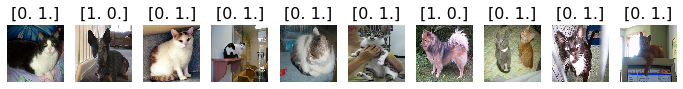

In [ ]:
imgs, labels = next(train_batches)
plots(imgs, titles=labels)

例如，猫不被称为“猫”，而是被称为[0,1]。 狗被称为[1,0]。

因为我们在这里只处理两个类，我们可以很好地选择使用二元分类，而不是分类分类。如果我们用二进制，那么我们就不用这里的2D标签，而是用由0或1组成的1D标签。

通过直观地检查上面的输出，我们知道Keras为每个猫和狗类别分配了哪些标签。如果我们不画出来呢?那么我们如何知道标签[0,1]对应的是猫还是狗呢

这就引出了一个问题，我们为什么还要关心？

回想一下，我们之前调用过model.predict_generator（），并将其传递给test_batches并打印出预测

In [ ]:
model = Sequential([
    Conv2D(filters=32,kernel_size=(3,3),activation='relu',padding='same',input_shape=(224,224,3)),
    # strides：步幅
    MaxPool2D(pool_size=(2,2),strides=2),
    Conv2D(filters=64,kernel_size=(3,3),activation='relu',padding='same'),
    MaxPool2D(pool_size=(2,2),strides=2),
    Flatten(),
    Dense(units=2,activation='softmax')
])

In [ ]:
model.compile(optimizer=Adam(learning_rate=0.0001),loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
model.fit(x=train_batches,
    steps_per_epoch=10,
    validation_data=valid_batches,
    validation_steps=10,
    epochs=2,
    verbose = 2
)

Epoch 1/2
10/10 - 8s - loss: 2.0315 - accuracy: 0.7400 - val_loss: 1.5765 - val_accuracy: 0.7250
Epoch 2/2
10/10 - 8s - loss: 0.7990 - accuracy: 0.8100 - val_loss: 4.9270 - val_accuracy: 0.6000


In [ ]:
predictions = model.predict_generator(test_batches, steps=1, verbose=0)
predictions

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


array([[1.0000000e+00, 3.2001200e-24],
       [1.0000000e+00, 2.2901220e-24],
       [8.5677159e-01, 1.4322837e-01],
       [1.0000000e+00, 3.0902612e-08],
       [3.9736229e-01, 6.0263765e-01],
       [9.9999976e-01, 1.9527249e-07],
       [8.4664726e-01, 1.5335271e-01],
       [9.9999869e-01, 1.2602851e-06],
       [9.9997568e-01, 2.4327695e-05],
       [1.0000000e+00, 3.4440734e-10]], dtype=float32)

在这种情况下，我们所有的预测都是[0,1]。 请注意，这是在调整模型以使其表现更好之前进行的，因此此处表现不佳，将所有事物归类为猫。

但是，如果我们不提前打印批次，就不会知道[0,1]矢量已映射到猫，因此这些预测对我们来说毫无意义。 我们不知道该模型是在预测猫还是狗。

我们需要能够理解哪个标签属于哪个类，而不必绘制数据。正是这个想法在论坛上被提出并被问及。我们如何知道哪个标签属于哪个类?

幸运的是，我们有一个非常直接的方法来做这个。

我们可以在ImageDataGenerator上访问一个名为class_indices的属性，它将返回包含从类名到类索引映射的字典。

我们来看看这是什么样子。我们可以在我们创建的任何ImageDatagenerators上调用它，test_batch、train_batch或valid_batch。

我们将用test_batch来演示这个。

运行代码test_batches.class_indices给出如下输出

In [ ]:
test_batches.class_indices

{'cat': 1, 'dog': 0}

我们看到，值1赋给了cat，值0赋给了dog。

但是…我们的值应该是一次性编码的向量，而不仅仅是0和1。

那么，到底发生了什么?

这个输出实际上给了我们对应值1在单热编码向量中的下标。

它表示猫对应的是1。通过查看上面讨论的图中的猫的图像，我们可以看到one-hot编码标签中的1的值确实是该向量的第一个索引。

对于狗来说，值1在第0个索引中，这就是为什么狗的类索引是0。

如果我们有另一个类别，蜥蜴，那么我们将有另一个元素来显示蜥蜴类对应于索引2。然后，我们所有的向量的长度都是3因为有三个分类。



```
{'lizard': 2, 'cat': 1, 'dog': 0}
```

在本例中，dog标签将为[1,0,0]。cat标签将为[0,1,0]。蜥蜴标签将是[0,0,1]。


希望本文澄清了关于如何访问Keras分配给类的标签以及为什么我们需要这些信息的困惑。